In [ ]:
import torch
import torchvision

print(torch.__version__)
print(torchvision.__version__)

2.2.1+cu121
0.17.1+cu121


# Data

In [ ]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

try:
    from going_modular import data_setup, engine
except:
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/Hrut7hesh/git_test
    !mv git_test/going_modular .
    !rm -rf git_test
    from going_modular import data_setup, engine

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular scripts... downloading them from GitHub.
Cloning into 'git_test'...
remote: Enumerating objects: 42, done.
remote: Counting objects: 100% (42/42), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 42 (delta 7), reused 8 (delta 0), pack-reused 0
Receiving objects: 100% (42/42), 16.35 MiB | 4.45 MiB/s, done.
Resolving deltas: 100% (7/7), done.


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
!nvidia-smi

Sat May  4 06:06:36 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8              11W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
import os
import zipfile

from pathlib import Path
import requests

data_path = Path("data/")
image_path = data_path / "pizza_chicken_wings_fried_rice"

if image_path.is_dir():
  print(f"{image_path} directory exists, skipping re-download.")
else:
  print(f"Did not find {image_path}, downloading it...")
  image_path.mkdir(parents=True, exist_ok=True)
  with open(data_path/"pizza_chicken_wings_fried_rice.zip", "wb") as f:
    request = requests.get('https://github.com/Hrut7hesh/git_test/raw/main/pizza_chicken_wings_fried_rice_10_percent.zip')
    print("Downloading data...")
    f.write(request.content)
  with zipfile.ZipFile(data_path / "pizza_chicken_wings_fried_rice.zip", "r") as zip_ref:
    print("Unzipping data...")
    zip_ref.extractall(image_path)
  os.remove(data_path / "pizza_chicken_wings_fried_rice.zip")

Did not find data/pizza_chicken_wings_fried_rice, downloading it...
Unzipping data...


In [ ]:
train_dir = image_path / "train"
test_dir = image_path / "test"
train_dir, test_dir

(PosixPath('data/pizza_chicken_wings_fried_rice/train'),
 PosixPath('data/pizza_chicken_wings_fried_rice/test'))

# DataLoaders

In [ ]:
# automatic
weights = torchvision.models.ResNet18_Weights.DEFAULT
weights

ResNet18_Weights.IMAGENET1K_V1

In [ ]:
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [ ]:
from going_modular import data_setup
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=auto_transforms,
                                                                               batch_size=32)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7d5af2b21a50>,
 ['chicken_wings', 'fried_rice', 'pizza'])

# Model

In [ ]:
weights = torchvision.models.ResNet18_Weights.DEFAULT
model = torchvision.models.resnet18(weights=weights).to(device)
model

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 136MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
model.fc

Linear(in_features=512, out_features=1000, bias=True)

In [ ]:
from torchinfo import summary
summary(model=model,
        input_size=(1,3,224,224),
        col_names=["input_size","output_size","num_params","trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [1, 3, 224, 224]     [1, 1000]            --                   True
├─Conv2d (conv1)                         [1, 3, 224, 224]     [1, 64, 112, 112]    9,408                True
├─BatchNorm2d (bn1)                      [1, 64, 112, 112]    [1, 64, 112, 112]    128                  True
├─ReLU (relu)                            [1, 64, 112, 112]    [1, 64, 112, 112]    --                   --
├─MaxPool2d (maxpool)                    [1, 64, 112, 112]    [1, 64, 56, 56]      --                   --
├─Sequential (layer1)                    [1, 64, 56, 56]      [1, 64, 56, 56]      --                   True
│    └─BasicBlock (0)                    [1, 64, 56, 56]      [1, 64, 56, 56]      --                   True
│    │    └─Conv2d (conv1)               [1, 64, 56, 56]      [1, 64, 56, 56]      36,864               True
│    │    └─BatchN

In [ ]:
for param in model.conv1.parameters():
  param.requires_grad=False
for param in model.bn1.parameters():
  param.requires_grad=False
for param in model.layer1.parameters():
  param.requires_grad=False
for param in model.layer2.parameters():
  param.requires_grad=False
for param in model.layer3.parameters():
  param.requires_grad=False
for param in model.layer4.parameters():
  param.requires_grad=False

In [ ]:
from torch import nn
torch.manual_seed(42)

model.fc=nn.Linear(in_features=512,out_features=len(class_names))
model.fc

Linear(in_features=512, out_features=3, bias=True)

In [ ]:
summary(model=model,
        input_size=(1,3,224,224),
        col_names=["input_size","output_size","num_params","trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Conv2d (conv1)                         [1, 3, 224, 224]     [1, 64, 112, 112]    (9,408)              False
├─BatchNorm2d (bn1)                      [1, 64, 112, 112]    [1, 64, 112, 112]    (128)                False
├─ReLU (relu)                            [1, 64, 112, 112]    [1, 64, 112, 112]    --                   --
├─MaxPool2d (maxpool)                    [1, 64, 112, 112]    [1, 64, 56, 56]      --                   --
├─Sequential (layer1)                    [1, 64, 56, 56]      [1, 64, 56, 56]      --                   False
│    └─BasicBlock (0)                    [1, 64, 56, 56]      [1, 64, 56, 56]      --                   False
│    │    └─Conv2d (conv1)               [1, 64, 56, 56]      [1, 64, 56, 56]      (36,864)             False
│    │    

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
from going_modular import engine
torch.manual_seed(42)
torch.cuda.manual_seed(42)
from timeit import default_timer as timer
start_time=timer()
results=engine.train(model=model,
                     train_dataloader=train_dataloader,
                     test_dataloader=test_dataloader,
                     optimizer=optimizer,
                     loss_fn=loss_fn,
                     epochs=10,
                     device=device)
end_time=timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 1 | train_loss: 1.0802 | train_acc: 0.5117 | test_loss: 1.0619 | test_acc: 0.4261
Epoch: 2 | train_loss: 0.9657 | train_acc: 0.5195 | test_loss: 0.7613 | test_acc: 0.7528
Epoch: 3 | train_loss: 0.8030 | train_acc: 0.7344 | test_loss: 0.7945 | test_acc: 0.6723
Epoch: 4 | train_loss: 0.7449 | train_acc: 0.7070 | test_loss: 0.6356 | test_acc: 0.8864
Epoch: 5 | train_loss: 0.6916 | train_acc: 0.7539 | test_loss: 0.6277 | test_acc: 0.7945
Epoch: 6 | train_loss: 0.6864 | train_acc: 0.7500 | test_loss: 0.5558 | test_acc: 0.8665
Epoch: 7 | train_loss: 0.5462 | train_acc: 0.9062 | test_loss: 0.5775 | test_acc: 0.8144
Epoch: 8 | train_loss: 0.6505 | train_acc: 0.7148 | test_loss: 0.5295 | test_acc: 0.8248
Epoch: 9 | train_loss: 0.6008 | train_acc: 0.7773 | test_loss: 0.4569 | test_acc: 0.8968
Epoch: 10 | train_loss: 0.6332 | train_acc: 0.7148 | test_loss: 0.3548 | test_acc: 0.9072
[INFO] Total training time: 31.244 seconds


In [ ]:
from tqdm.auto import tqdm

test_preds = []
model.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader):
    X, y = X.to(device), y.to(device)
    test_logits = model(X)
    pred_probs = torch.softmax(test_logits, dim=1)
    pred_labels = torch.argmax(pred_probs, dim=1)
    test_preds.append(pred_labels)

test_preds = torch.cat(test_preds).cpu()
test_preds

  0%|          | 0/3 [00:00<?, ?it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 2,
        0, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 0, 1, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0,
        2, 2, 2])

In [ ]:
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 28.9 MB/s eta 0:00:00
mlxtend version: 0.23.1


In [ ]:
test_truth = torch.cat([y for X, y in test_dataloader])
test_truth

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2])

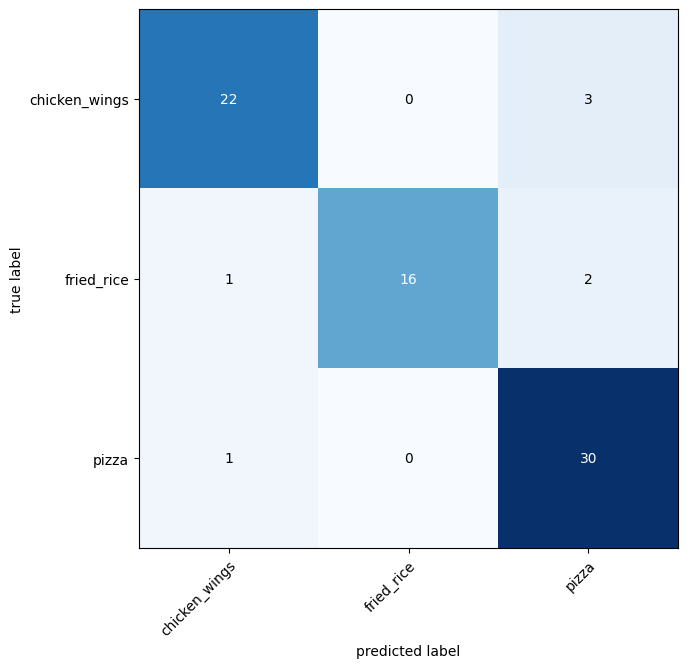

In [ ]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds=test_preds,
                         target=test_truth)

fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names=class_names,
    figsize=(10, 7)
)

[INFO] Couldn't find helper_functions.py, downloading...


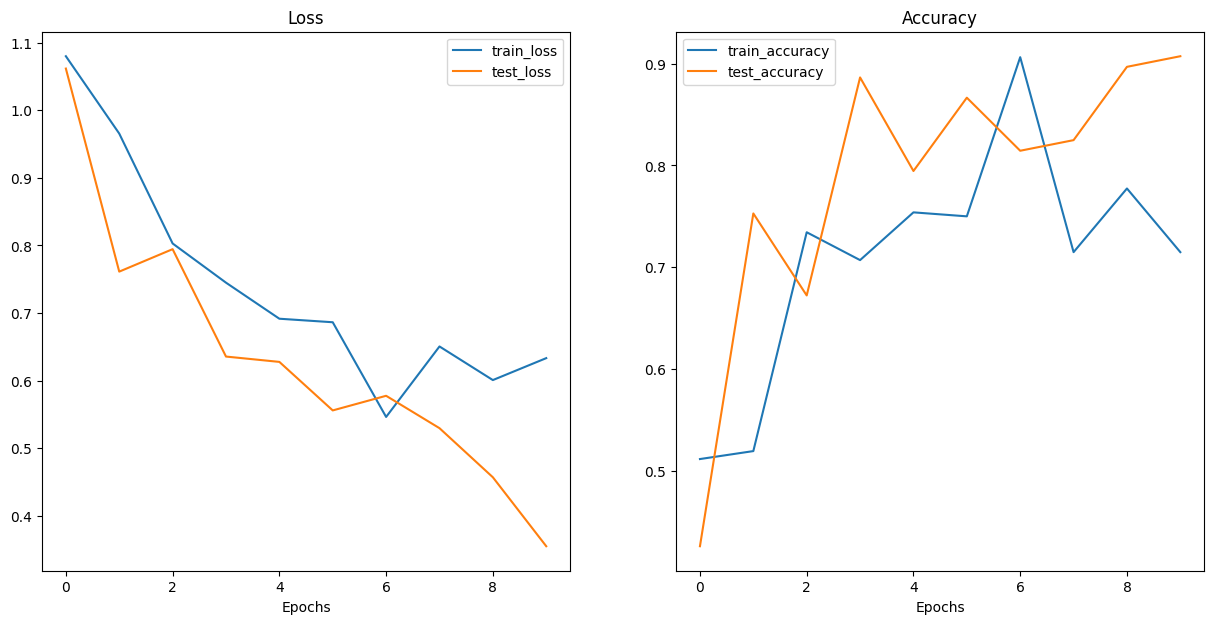

In [ ]:
try:
  from helper_functions import plot_loss_curves
except:
  print(f"[INFO] Couldn't find helper_functions.py, downloading...")
  with open("helper_functions.py", "wb") as f:
    import requests
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    f.write(request.content)
  from helper_functions import plot_loss_curves
plot_loss_curves(results)

In [ ]:
from typing import List, Tuple

from PIL import Image
from torchvision import transforms

def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str],
                        image_size: Tuple[int, int]=(224, 224),
                        transform: torchvision.transforms = None,
                        device: torch.device=device):
  img = Image.open(image_path)
  if transform is not None:
    image_transform = transform
  else:
    image_transform = transforms.Compose([transforms.Resize(image_size),
                                         transforms.ToTensor(),
                                         transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                              std=[0.229, 0.224, 0.225])])
  model.to(device)
  model.eval()
  with torch.inference_mode():
    transformed_image = image_transform(img).unsqueeze(dim=0)
    target_image_pred = model(transformed_image.to(device))
  target_image_pred_probs = torch.softmax(target_image_pred, dim=1)
  target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)
  plt.figure()
  plt.imshow(img)
  plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
  plt.axis(False);

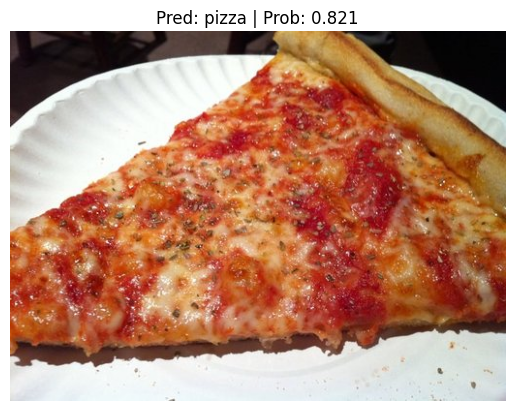

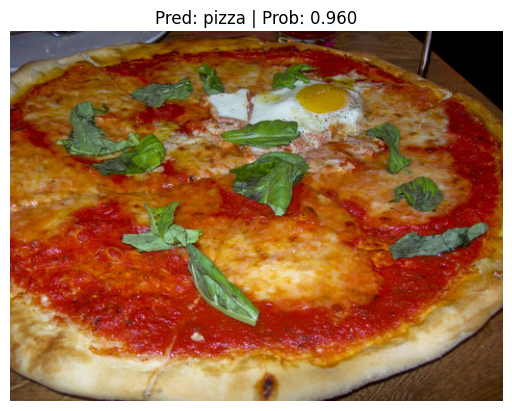

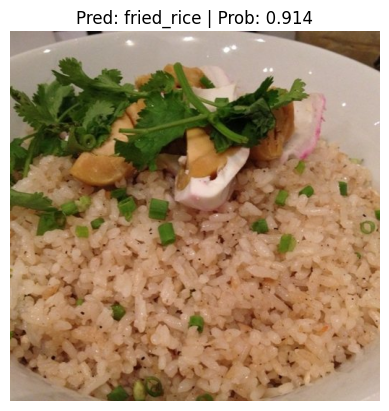

In [ ]:
import random
num_images_to_plot = 3
test_image_path_list = list(Path(test_dir).glob("*/*.jpg"))
test_image_path_sample = random.sample(population=test_image_path_list,
                                       k=num_images_to_plot)
for image_path in test_image_path_sample:
  pred_and_plot_image(model=model,
                      image_path=image_path,
                      class_names=class_names,
                      image_size=(224, 224))

In [ ]:
import requests
custom_image_path = data_path / "fried_rice.jpg"
if not custom_image_path.is_file():
  with open(custom_image_path, "wb") as f:
    request=requests.get("https://raw.githubusercontent.com/Hrut7hesh/git_test/main/fried_rice.jpg")
    print(f"Downloading {custom_image_path}...")
    f.write(request.content)
else:
  print(f"{custom_image_path} already exists, skipping download...")

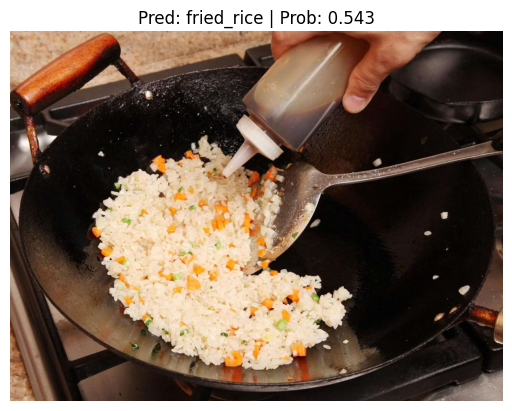

In [ ]:
pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names,
                    image_size=(224, 224))